# 1. DQN Algorithms

PPO is motivated by the following question: how can we take the biggest possible improvement step on a policy using the data we currently have, without stepping so far that we accidentally cause performance collapse? The main idea is that after an update, the new policy should be not too far form the old policy. For that, PPO (as implemented in Stable Baselines) uses clipping to avoid too large update.


### Quick Facts

* DQN is an off-policy algorithm.
* DQN can only be used for environments with discrete action spaces.
* The Stable Baselines implementation of PPO follows the OpenAI made for GPU. For multiprocessing, it uses vectorized environment.


### Key Equations


Our aim will be to train a policy that tries to maximize the discounted, cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where $R_{t_0}$ is also known as the *return*. The discount, $\gamma$, should be a constant between $0$ and $1$ that ensures the sum converges. It makes rewards from the uncertain far future less important for our agent than the ones in the near future that it can be fairly confident about.

The main idea behind Q-learning is that if we had a function $Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell us what our return would be, if we were to take an action in a given state, then we could easily construct a policy that maximizes our
rewards:

\begin{equation}
 \pi^*(s) = \arg\!\max_a \ Q^*(s, a)
\end{equation}

However, we don't know everything about the world, so we don't have access to $Q^*$. But, since neural networks are universal function approximators, we can simply create one and train it to resemble $Q^*$.

For our training update rule, we'll use a fact that every $Q$ function for some policy obeys the Bellman equation:

\begin{equation}
 Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))
\end{equation}

The difference between the two sides of the equality is known as the temporal difference error, $\delta$:

\begin{equation}
 \delta = Q(s, a) - (r + \gamma \max_a Q(s', a))
\end{equation}

To minimise this error, we will use the `Huber loss` (https://en.wikipedia.org/wiki/Huber_loss). The Huber loss acts like the mean squared error when the error is small, but like the mean absolute error when the error is large - this makes it more robust to outliers when the estimates of $Q$ are very noisy. We calculate this over a batch of transitions, $B$, sampled from the replay memory:

\begin{equation}
\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)
\end{equation}

where

\begin{equation}
\quad \mathcal{L}(\delta) = \begin{cases}
 \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
 |\delta| - \frac{1}{2} & \text{otherwise.}
  \end{cases}
\end{equation}

### Replay Buffer
We’ll be using experience replay memory for training our DQN. It stores the transitions that the agent observes, allowing us to reuse this data later. By sampling from it randomly, the transitions that build up a batch are decorrelated. It has been shown that this greatly stabilizes and improves the DQN training procedure


### Exploration vs. Exploitation

Stable Baselines DQN implementation uses a trick to improve exploration at the start of training. For a fixed number of steps at the beginning, the agent takes actions which are sampled from a uniform random distribution over valid actions. After that, it returns to normal DQN exploration.


### Implementation Notes (Stable Baselines)

By default, the DQN class has double q learning and dueling extensions enabled. 

#### Can I use?

-  Recurrent policies: ❌
-  Multi processing: ❌
-  Gym spaces:



| Space         | Action | Observation |  
| --- | --- | --- |   
|Discrete |      ✔️|      ✔️ |  
|Box      |      ❌ |      ✔️ | 
|MultiDiscrete | ❌ |      ✔️ | 
|MultiBinary |   ❌ |      ✔️ |

## 1.1 Import Required Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gym
import time
import numpy as np

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN
import matplotlib.pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## 1.2 Training Configuration
### Parameters

* **ENV_NAME**: the name of the Gym Environment for training
* **EVAL_STEPS**: number of samples to be used for policy evaluation. Here, the horizon $H$ is 200 steps, so the evaulation is 2000 / 200 = 10 episodes
* **ITERS**: number of simulation time-steps during training. Here corresponds to 250 episodes

In [2]:
ENV_NAME = 'CartPole-v0'
EVAL_STEPS = 2000
ITERS = 50000

## 1.3 Logging
### Logging Directories

* **PPO2_Cartpole**: the directory used for the tensorboard
* **Results**: the directory where the intermediate trained agents are stored

In [3]:
def logs_gen(net_size):
    tensorboard_log = "./DQN_Cartpole/2x" + str(net_size)
    log_dir = "./Results/"
    return log_dir, tensorboard_log

## 1.4 Environment Definition
### Vectorized Environments

Vectorized Environments are a method for stacking multiple independent environments into a single environment. Instead of training an RL agent on 1 environment per step, it allows us to train it on n environments per step. Because of this, actions passed to the environment are now a vector (of dimension n). It is the same for observations, rewards and end of episode signals (dones). In the case of non-array observation spaces such as Dict or Tuple, where different sub-spaces may have different shapes, the sub-observations are vectors (of dimension n).

In [4]:
env = gym.make('CartPole-v0')
env = DummyVecEnv([lambda: env])

## 1.5 Agent Definition
### Agent Parameters

* **MlpPolicy**: The policy model to use (MlpPolicy, CnnPolicy, CnnLstmPolicy, …)
* **policy_kwargs**: the Network Architecture (here 2 hiden layers with size 256)
* **env**: the Gym Environment
* **learning_rate**: learning rate for adam optimizer
* **buffer_size**: size of the replay buffer
* **gamma**: Discount factor
* **exploration_fraction**:  fraction of entire training period over which the exploration rate is annealed
* **exploration_final_eps**: final value of random action probability
* **exploration_initial_eps**: initial value of random action probability
* **train_freq**: update the model every train_freq steps
* **batch_size**: size of a batched sampled from replay buffer for training
* **double_q**: Whether to enable Double-Q learning or not (always do this!)
* **learning_starts**: how many steps of the model to collect transitions for before learning starts
* **target_network_update_freq**: update the target network every target_network_update_freq steps
* **prioritized_replay**: if True prioritized replay buffer will be used
* **tensorboard_log**: the log location for tensorboar

In [5]:
hidden_layer_size = 256
policy_kwargs = dict(layers=[hidden_layer_size, hidden_layer_size])
log_dir, tensorboard_log = logs_gen(hidden_layer_size)

model = DQN(MlpPolicy, env, gamma=0.99, learning_rate=0.001, buffer_size=50000, policy_kwargs=policy_kwargs,
            exploration_fraction=0.1, exploration_final_eps=0.02, exploration_initial_eps=1.0,
            train_freq=1, batch_size=32, double_q=True,
            learning_starts=1000, target_network_update_freq=500,
            prioritized_replay=False, verbose=1, tensorboard_log=tensorboard_log)







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









## 1.6 Define a callback function
We can define a custom callback function that will be called inside the agent. This could be useful when we want to monitor training, for instance display live learning curves in Tensorboard or save the best agent.

In [6]:
best_mean_reward, n_steps = -np.inf, 0
evaluation_rewards = []

def callback(_locals, _globals):
    """
  Callback called at each step
  :param _locals: (dict)
  :param _globals: (dict)
  """
    global n_steps, best_mean_reward
    # Print stats every 1000 calls
    if (n_steps + 1) % 1000 == 0:
        print("-----------------------------------------------------")
        print("Evaluating Model: " + str(n_steps))
        rew = evaluate(model, num_steps=EVAL_STEPS, render=False)
        print("Best mean reward: {:.15f} - Last mean reward per episode: {:.15f}".format(best_mean_reward, rew))
        _locals['self'].save(log_dir + 'model_' + str(n_steps))
        if (rew > best_mean_reward):
            best_mean_reward = rew
            print("Saving new best model")
            _locals['self'].save(log_dir + 'best_model')
    n_steps += 1
    return True

## 1.7 Define an evaluation function

During training the action selection is subject to the exploration scheme defined. This implies that policy A could be better than policy B but appear to perform worse due to the effect of the exploration.

Due to this, in order to determine the best policy throughout the entire training phase, in each Callback we evaluate the current policy without exploration (deterministic actions); if the current policy is better than the best policy found so far, we simply override the best policy.

In [7]:
def evaluate(model, num_steps=300, render=False):
    global evaluation_rewards
    print("EVALUATION!!!")
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_steps: (int) number of timesteps to evaluate it
    :return: (float) Mean reward
    """
    episode_rewards = [[0.0] for _ in range(env.num_envs)]
    obs = env.reset()
    # print(obs)
    for i in range(num_steps - 1):
        # _states are only useful when using LSTM policies
        actions, _ = model.predict(obs, deterministic=True)
        # here, action, rewards and dones are arrays
        # because we are using vectorized env
        obs, rewards, dones, info = env.step(actions)

        if (render):
            env.render()

        for j in range(env.num_envs):
            episode_rewards[j][-1] += rewards[j]
            if dones[j]:
                episode_rewards[j].append(0.0)

    mean_rewards = [0.0 for _ in range(env.num_envs)]
    n_episodes = 0
    for i in range(env.num_envs):
        mean_rewards[i] = np.mean(episode_rewards[i])
        n_episodes += len(episode_rewards[i])

    # Compute mean reward
    mean_reward = round(np.mean(mean_rewards), 1)
    print("Mean reward:", mean_reward, "Num episodes:", n_episodes)
    evaluation_rewards.append(mean_reward)

    return mean_reward

## 1.8 Evaluate the Agent before training

In [8]:
rew = evaluate(model, num_steps=EVAL_STEPS, render=False)

EVALUATION!!!
Mean reward: 29.0 Num episodes: 69


## 1.9 Train the DQN Agent 
![DQN Algorithm](img/DQN.svg)

In [9]:
start_time = time.time()
model.learn(total_timesteps=ITERS, callback=callback)
elapsed_time = time.time() - start_time
print("-----------------------------------------------------")
print("Training Time: " + str(elapsed_time))




-----------------------------------------------------
Evaluating Model: 999
EVALUATION!!!
Mean reward: 28.2 Num episodes: 71
Best mean reward: -inf - Last mean reward per episode: 28.199999999999999
Saving new best model


-----------------------------------------------------
Evaluating Model: 1999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 215
Best mean reward: 28.199999999999999 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 58       |
| episodes                | 100      |
| mean 100 episode reward | 21.6     |
| steps                   | 2139     |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 2999
EVALUATION!!!
Mean reward: 105.2 Num episodes: 19
Best mean reward: 28.199999999999999 - Last mean reward per episode: 105.200000000000003
Saving new best model
-----------------------------------------------------
Evaluating Model: 3999
EVALUATION!!

Mean reward: 95.2 Num episodes: 21
Best mean reward: 199.900000000000006 - Last mean reward per episode: 95.200000000000003
-----------------------------------------------------
Evaluating Model: 30999
EVALUATION!!!
Mean reward: 117.6 Num episodes: 17
Best mean reward: 199.900000000000006 - Last mean reward per episode: 117.599999999999994
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 400      |
| mean 100 episode reward | 90.8     |
| steps                   | 31253    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 31999
EVALUATION!!!
Mean reward: 90.9 Num episodes: 22
Best mean reward: 199.900000000000006 - Last mean reward per episode: 90.900000000000006
-----------------------------------------------------
Evaluating Model: 32999
EVALUATION!!!
Mean reward: 83.3 Num episodes: 24
Best mean reward: 199.900000000000006 - Last mean reward per episode: 83.29999999

## 1.10 Plot the total reward of the policies evaluated in the Callback (deterministic)

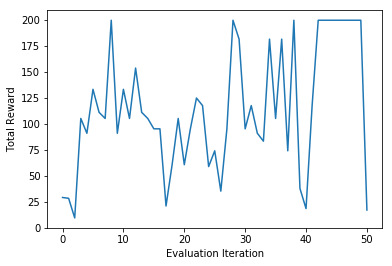

In [10]:
plt.plot(evaluation_rewards)
plt.ylabel('Total Reward')
plt.xlabel('Evaluation Iteration')
plt.show()

## 1.11 Evaluate the best Agent after training

In [13]:
model = DQN.load(log_dir + 'best_model', env=env)
r = evaluate(model, num_steps=EVAL_STEPS, render=True)

EVALUATION!!!
Mean reward: 199.9 Num episodes: 10


## 1.12 Close environment

In [14]:
env.close()

## 1.13 How each parameter affects the performance of the Algorithm?

In [15]:
hid_layer_height_list = [2, 64, 128, 256]
hid_layer_list = [1,2]

lr_list = [0.00001, 0.001, 0.1]
buf_list = [32, 5000, 50000]
solved = []

In [17]:
# network layer tests
for num_layers in hid_layer_list:
    for hidden_layer_size in hid_layer_height_list:
        layer_str = str(num_layers) + "x" + str(hidden_layer_size)
        print("---------------------------------------------")
        print("Layer Size = " + layer_str)
        print("---------------------------------------------")
        _layers = []
        for l in range(num_layers):
            _layers.append(hidden_layer_size)
        policy_kwargs = dict(layers=_layers)

        tensorboard_log = "./DQN_Cartpole_Param/network_size_" + layer_str
        log_dir = "./Results/"

        model = DQN(MlpPolicy, env, gamma=0.99, learning_rate=0.001, buffer_size=50000, policy_kwargs=policy_kwargs,
                    exploration_fraction=0.1, exploration_final_eps=0.02, exploration_initial_eps=1.0,
                    train_freq=1, batch_size=32, double_q=True,
                    learning_starts=1000, target_network_update_freq=500,
                    prioritized_replay=False, verbose=1, tensorboard_log=tensorboard_log)

        best_mean_reward, n_steps = -np.inf, 0
        evaluation_rewards = []

        start_time = time.time()
        model.learn(total_timesteps=ITERS, callback=callback)
        elapsed_time = time.time() - start_time
        print("Training Time: " + str(elapsed_time))

        model = DQN.load(log_dir + 'best_model', env=env)
        r = evaluate(model, num_steps=EVAL_STEPS, render=False)

        solved.append(r)

---------------------------------------------
Layer Size = 1x2
---------------------------------------------
-----------------------------------------------------
Evaluating Model: 999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 215
Best mean reward: -inf - Last mean reward per episode: 9.300000000000001
Saving new best model
--------------------------------------
| % time spent exploring  | 61       |
| episodes                | 100      |
| mean 100 episode reward | 19.9     |
| steps                   | 1966     |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 1999
EVALUATION!!!
Mean reward: 9.4 Num episodes: 213
Best mean reward: 9.300000000000001 - Last mean reward per episode: 9.400000000000000
Saving new best model
-----------------------------------------------------
Evaluating Model: 2999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 215
Best mean reward: 9.400000000000000 - Last mean reward per episode: 9.3000000

-----------------------------------------------------
Evaluating Model: 18999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 214
Best mean reward: 10.100000000000000 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1900     |
| mean 100 episode reward | 9.6      |
| steps                   | 19778    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 19999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 214
Best mean reward: 10.100000000000000 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 2000     |
| mean 100 episode reward | 9.6      |
| steps                   | 20735    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 20999
EVALUATION!!!
Mean reward:

-----------------------------------------------------
Evaluating Model: 36999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 214
Best mean reward: 10.100000000000000 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3800     |
| mean 100 episode reward | 9.4      |
| steps                   | 37682    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 37999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 214
Best mean reward: 10.100000000000000 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3900     |
| mean 100 episode reward | 9.4      |
| steps                   | 38618    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 38999
EVALUATION!!!
Mean reward:

-----------------------------------------------------
Evaluating Model: 7999
EVALUATION!!!
Mean reward: 166.6 Num episodes: 12
Best mean reward: 181.699999999999989 - Last mean reward per episode: 166.599999999999994
-----------------------------------------------------
Evaluating Model: 8999
EVALUATION!!!
Mean reward: 166.6 Num episodes: 12
Best mean reward: 181.699999999999989 - Last mean reward per episode: 166.599999999999994
-----------------------------------------------------
Evaluating Model: 9999
EVALUATION!!!
Mean reward: 142.8 Num episodes: 14
Best mean reward: 181.699999999999989 - Last mean reward per episode: 142.800000000000011
-----------------------------------------------------
Evaluating Model: 10999
EVALUATION!!!
Mean reward: 133.3 Num episodes: 15
Best mean reward: 181.699999999999989 - Last mean reward per episode: 133.300000000000011
-----------------------------------------------------
Evaluating Model: 11999
EVALUATION!!!
Mean reward: 133.3 Num episodes: 15
Bes

-----------------------------------------------------
Evaluating Model: 42999
EVALUATION!!!
Mean reward: 124.9 Num episodes: 16
Best mean reward: 181.699999999999989 - Last mean reward per episode: 124.900000000000006
-----------------------------------------------------
Evaluating Model: 43999
EVALUATION!!!
Mean reward: 133.3 Num episodes: 15
Best mean reward: 181.699999999999989 - Last mean reward per episode: 133.300000000000011
-----------------------------------------------------
Evaluating Model: 44999
EVALUATION!!!
Mean reward: 124.9 Num episodes: 16
Best mean reward: 181.699999999999989 - Last mean reward per episode: 124.900000000000006
-----------------------------------------------------
Evaluating Model: 45999
EVALUATION!!!
Mean reward: 133.3 Num episodes: 15
Best mean reward: 181.699999999999989 - Last mean reward per episode: 133.300000000000011
-----------------------------------------------------
Evaluating Model: 46999
EVALUATION!!!
Mean reward: 142.8 Num episodes: 14


Mean reward: 117.6 Num episodes: 17
Best mean reward: 199.900000000000006 - Last mean reward per episode: 117.599999999999994
-----------------------------------------------------
Evaluating Model: 27999
EVALUATION!!!
Mean reward: 199.9 Num episodes: 10
Best mean reward: 199.900000000000006 - Last mean reward per episode: 199.900000000000006
-----------------------------------------------------
Evaluating Model: 28999
EVALUATION!!!
Mean reward: 199.9 Num episodes: 10
Best mean reward: 199.900000000000006 - Last mean reward per episode: 199.900000000000006
-----------------------------------------------------
Evaluating Model: 29999
EVALUATION!!!
Mean reward: 124.9 Num episodes: 16
Best mean reward: 199.900000000000006 - Last mean reward per episode: 124.900000000000006
-----------------------------------------------------
Evaluating Model: 30999
EVALUATION!!!
Mean reward: 153.8 Num episodes: 13
Best mean reward: 199.900000000000006 - Last mean reward per episode: 153.800000000000011
--

-----------------------------------------------------
Evaluating Model: 10999
EVALUATION!!!
Mean reward: 117.6 Num episodes: 17
Best mean reward: 181.699999999999989 - Last mean reward per episode: 117.599999999999994
-----------------------------------------------------
Evaluating Model: 11999
EVALUATION!!!
Mean reward: 100.0 Num episodes: 20
Best mean reward: 181.699999999999989 - Last mean reward per episode: 100.000000000000000
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 200      |
| mean 100 episode reward | 102      |
| steps                   | 12462    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 12999
EVALUATION!!!
Mean reward: 100.0 Num episodes: 20
Best mean reward: 181.699999999999989 - Last mean reward per episode: 100.000000000000000
-----------------------------------------------------
Evaluating Model: 13999
EVALUATION!!!
Mean reward: 117.6 N

Mean reward: 117.6 Num episodes: 17
Best mean reward: 181.699999999999989 - Last mean reward per episode: 117.599999999999994
-----------------------------------------------------
Evaluating Model: 45999
EVALUATION!!!
Mean reward: 142.8 Num episodes: 14
Best mean reward: 181.699999999999989 - Last mean reward per episode: 142.800000000000011
-----------------------------------------------------
Evaluating Model: 46999
EVALUATION!!!
Mean reward: 133.3 Num episodes: 15
Best mean reward: 181.699999999999989 - Last mean reward per episode: 133.300000000000011
-----------------------------------------------------
Evaluating Model: 47999
EVALUATION!!!
Mean reward: 124.9 Num episodes: 16
Best mean reward: 181.699999999999989 - Last mean reward per episode: 124.900000000000006
-----------------------------------------------------
Evaluating Model: 48999
EVALUATION!!!
Mean reward: 124.9 Num episodes: 16
Best mean reward: 181.699999999999989 - Last mean reward per episode: 124.900000000000006
--

Mean reward: 9.3 Num episodes: 215
Best mean reward: 50.000000000000000 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1600     |
| mean 100 episode reward | 9.4      |
| steps                   | 16705    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 16999
EVALUATION!!!
Mean reward: 9.4 Num episodes: 213
Best mean reward: 50.000000000000000 - Last mean reward per episode: 9.400000000000000
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1700     |
| mean 100 episode reward | 9.4      |
| steps                   | 17642    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 17999
EVALUATION!!!
Mean reward: 9.2 Num episodes: 217
Best mean reward: 50.000000000000000 - Last mean reward per episode: 

-----------------------------------------------------
Evaluating Model: 33999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 214
Best mean reward: 50.000000000000000 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3500     |
| mean 100 episode reward | 9.4      |
| steps                   | 34673    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 34999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 216
Best mean reward: 50.000000000000000 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3600     |
| mean 100 episode reward | 9.4      |
| steps                   | 35617    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 35999
EVALUATION!!!
Mean reward:

-----------------------------------------------------
Evaluating Model: 2999
EVALUATION!!!
Mean reward: 199.9 Num episodes: 10
Best mean reward: 66.599999999999994 - Last mean reward per episode: 199.900000000000006
Saving new best model
-----------------------------------------------------
Evaluating Model: 3999
EVALUATION!!!
Mean reward: 86.9 Num episodes: 23
Best mean reward: 199.900000000000006 - Last mean reward per episode: 86.900000000000006
-----------------------------------------------------
Evaluating Model: 4999
EVALUATION!!!
Mean reward: 142.8 Num episodes: 14
Best mean reward: 199.900000000000006 - Last mean reward per episode: 142.800000000000011
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 100      |
| mean 100 episode reward | 60.2     |
| steps                   | 5962     |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 5999
EVALUATION!!!
Mean 

Mean reward: 51.3 Num episodes: 39
Best mean reward: 199.900000000000006 - Last mean reward per episode: 51.299999999999997
-----------------------------------------------------
Evaluating Model: 37999
EVALUATION!!!
Mean reward: 124.9 Num episodes: 16
Best mean reward: 199.900000000000006 - Last mean reward per episode: 124.900000000000006
-----------------------------------------------------
Evaluating Model: 38999
EVALUATION!!!
Mean reward: 100.0 Num episodes: 20
Best mean reward: 199.900000000000006 - Last mean reward per episode: 100.000000000000000
-----------------------------------------------------
Evaluating Model: 39999
EVALUATION!!!
Mean reward: 19.4 Num episodes: 103
Best mean reward: 199.900000000000006 - Last mean reward per episode: 19.399999999999999
-----------------------------------------------------
Evaluating Model: 40999
EVALUATION!!!
Mean reward: 124.9 Num episodes: 16
Best mean reward: 199.900000000000006 - Last mean reward per episode: 124.900000000000006
-----

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 300      |
| mean 100 episode reward | 86.6     |
| steps                   | 20273    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 20999
EVALUATION!!!
Mean reward: 105.2 Num episodes: 19
Best mean reward: 166.599999999999994 - Last mean reward per episode: 105.200000000000003
-----------------------------------------------------
Evaluating Model: 21999
EVALUATION!!!
Mean reward: 90.9 Num episodes: 22
Best mean reward: 166.599999999999994 - Last mean reward per episode: 90.900000000000006
-----------------------------------------------------
Evaluating Model: 22999
EVALUATION!!!
Mean reward: 90.9 Num episodes: 22
Best mean reward: 166.599999999999994 - Last mean reward per episode: 90.900000000000006
-----------------------------------------------------
Evaluating Model: 23999
EVALUATION!!!
Mean reward: 90.9 Num ep

Mean reward: 124.9 Num episodes: 16
Best mean reward: 30.300000000000001 - Last mean reward per episode: 124.900000000000006
Saving new best model
-----------------------------------------------------
Evaluating Model: 3999
EVALUATION!!!
Mean reward: 105.2 Num episodes: 19
Best mean reward: 124.900000000000006 - Last mean reward per episode: 105.200000000000003
-----------------------------------------------------
Evaluating Model: 4999
EVALUATION!!!
Mean reward: 105.2 Num episodes: 19
Best mean reward: 124.900000000000006 - Last mean reward per episode: 105.200000000000003
-----------------------------------------------------
Evaluating Model: 5999
EVALUATION!!!
Mean reward: 76.9 Num episodes: 26
Best mean reward: 124.900000000000006 - Last mean reward per episode: 76.900000000000006
-----------------------------------------------------
Evaluating Model: 6999
EVALUATION!!!
Mean reward: 95.2 Num episodes: 21
Best mean reward: 124.900000000000006 - Last mean reward per episode: 95.20000

-----------------------------------------------------
Evaluating Model: 37999
EVALUATION!!!
Mean reward: 166.6 Num episodes: 12
Best mean reward: 199.900000000000006 - Last mean reward per episode: 166.599999999999994
-----------------------------------------------------
Evaluating Model: 38999
EVALUATION!!!
Mean reward: 14.2 Num episodes: 141
Best mean reward: 199.900000000000006 - Last mean reward per episode: 14.199999999999999
-----------------------------------------------------
Evaluating Model: 39999
EVALUATION!!!
Mean reward: 199.9 Num episodes: 10
Best mean reward: 199.900000000000006 - Last mean reward per episode: 199.900000000000006
-----------------------------------------------------
Evaluating Model: 40999
EVALUATION!!!
Mean reward: 199.9 Num episodes: 10
Best mean reward: 199.900000000000006 - Last mean reward per episode: 199.900000000000006
-----------------------------------------------------
Evaluating Model: 41999
EVALUATION!!!
Mean reward: 199.9 Num episodes: 10
B

In [21]:
# learning rate tests
for ii in lr_list:
    hidden_layer_size = 128
    policy_kwargs = dict(layers=[hidden_layer_size])
    learning_rate = ii
    print("---------------------------------------------")
    print("Learning Rate = " + str(learning_rate))
    print("---------------------------------------------")

    tensorboard_log = "./DQN_Cartpole_Param/learning_rate_" + str(learning_rate)
    log_dir = "./Results/"

    model = DQN(MlpPolicy, env, gamma=0.99, learning_rate=learning_rate, buffer_size=50000,
                policy_kwargs=policy_kwargs,
                exploration_fraction=0.1, exploration_final_eps=0.02, exploration_initial_eps=1.0,
                train_freq=1, batch_size=32, double_q=True,
                learning_starts=1000, target_network_update_freq=500,
                prioritized_replay=False, verbose=1, tensorboard_log=tensorboard_log)

    best_mean_reward, n_steps = -np.inf, 0
    evaluation_rewards = []

    start_time = time.time()
    model.learn(total_timesteps=ITERS, callback=callback)
    elapsed_time = time.time() - start_time
    print("Training Time: " + str(elapsed_time))

    model = DQN.load(log_dir + 'best_model', env=env)
    r = evaluate(model, num_steps=EVAL_STEPS, render=False)
    
    solved.append(r)

---------------------------------------------
Learning Rate = 1e-05
---------------------------------------------
-----------------------------------------------------
Evaluating Model: 999
EVALUATION!!!
Mean reward: 21.3 Num episodes: 94
Best mean reward: -inf - Last mean reward per episode: 21.300000000000001
Saving new best model
-----------------------------------------------------
Evaluating Model: 1999
EVALUATION!!!
Mean reward: 10.2 Num episodes: 196
Best mean reward: 21.300000000000001 - Last mean reward per episode: 10.199999999999999
--------------------------------------
| % time spent exploring  | 57       |
| episodes                | 100      |
| mean 100 episode reward | 22.1     |
| steps                   | 2183     |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 2999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 214
Best mean reward: 21.300000000000001 - Last mean reward per episode: 9.300000000000001
---

Mean reward: 9.3 Num episodes: 214
Best mean reward: 21.300000000000001 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1900     |
| mean 100 episode reward | 9.4      |
| steps                   | 19625    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 19999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 214
Best mean reward: 21.300000000000001 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 2000     |
| mean 100 episode reward | 9.3      |
| steps                   | 20558    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 20999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 215
Best mean reward: 21.300000000000001 - Last mean reward per episode: 

-----------------------------------------------------
Evaluating Model: 36999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 215
Best mean reward: 21.300000000000001 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3800     |
| mean 100 episode reward | 9.4      |
| steps                   | 37550    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 37999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 214
Best mean reward: 21.300000000000001 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3900     |
| mean 100 episode reward | 9.4      |
| steps                   | 38495    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 38999
EVALUATION!!!
Mean reward:

-----------------------------------------------------
Evaluating Model: 7999
EVALUATION!!!
Mean reward: 181.7 Num episodes: 11
Best mean reward: 181.699999999999989 - Last mean reward per episode: 181.699999999999989
-----------------------------------------------------
Evaluating Model: 8999
EVALUATION!!!
Mean reward: 181.7 Num episodes: 11
Best mean reward: 181.699999999999989 - Last mean reward per episode: 181.699999999999989
-----------------------------------------------------
Evaluating Model: 9999
EVALUATION!!!
Mean reward: 153.8 Num episodes: 13
Best mean reward: 181.699999999999989 - Last mean reward per episode: 153.800000000000011
-----------------------------------------------------
Evaluating Model: 10999
EVALUATION!!!
Mean reward: 133.3 Num episodes: 15
Best mean reward: 181.699999999999989 - Last mean reward per episode: 133.300000000000011
-----------------------------------------------------
Evaluating Model: 11999
EVALUATION!!!
Mean reward: 105.2 Num episodes: 19
Bes

Mean reward: 153.8 Num episodes: 13
Best mean reward: 199.900000000000006 - Last mean reward per episode: 153.800000000000011
-----------------------------------------------------
Evaluating Model: 42999
EVALUATION!!!
Mean reward: 181.7 Num episodes: 11
Best mean reward: 199.900000000000006 - Last mean reward per episode: 181.699999999999989
-----------------------------------------------------
Evaluating Model: 43999
EVALUATION!!!
Mean reward: 153.8 Num episodes: 13
Best mean reward: 199.900000000000006 - Last mean reward per episode: 153.800000000000011
-----------------------------------------------------
Evaluating Model: 44999
EVALUATION!!!
Mean reward: 142.8 Num episodes: 14
Best mean reward: 199.900000000000006 - Last mean reward per episode: 142.800000000000011
-----------------------------------------------------
Evaluating Model: 45999
EVALUATION!!!
Mean reward: 142.8 Num episodes: 14
Best mean reward: 199.900000000000006 - Last mean reward per episode: 142.800000000000011
--

Mean reward: 9.3 Num episodes: 214
Best mean reward: 9.500000000000000 - Last mean reward per episode: 9.300000000000001
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1400     |
| mean 100 episode reward | 9.3      |
| steps                   | 15562    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 15999
EVALUATION!!!
Mean reward: 9.4 Num episodes: 213
Best mean reward: 9.500000000000000 - Last mean reward per episode: 9.400000000000000
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 1500     |
| mean 100 episode reward | 9.2      |
| steps                   | 16483    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 16999
EVALUATION!!!
Mean reward: 9.4 Num episodes: 213
Best mean reward: 9.500000000000000 - Last mean reward per episode: 9.4

Mean reward: 9.4 Num episodes: 213
Best mean reward: 9.500000000000000 - Last mean reward per episode: 9.400000000000000
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3300     |
| mean 100 episode reward | 9.4      |
| steps                   | 33494    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 33999
EVALUATION!!!
Mean reward: 9.2 Num episodes: 217
Best mean reward: 9.500000000000000 - Last mean reward per episode: 9.199999999999999
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 3400     |
| mean 100 episode reward | 9.6      |
| steps                   | 34456    |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 34999
EVALUATION!!!
Mean reward: 9.3 Num episodes: 214
Best mean reward: 9.500000000000000 - Last mean reward per episode: 9.3

In [22]:
# replay buffer tests
for ii in buf_list:
    hidden_layer_size = 128
    policy_kwargs = dict(layers=[hidden_layer_size])
    buffer_size = ii
    print("---------------------------------------------")
    print("Buffer Size = " + str(buffer_size))
    print("---------------------------------------------")

    tensorboard_log = "./DQN_Cartpole_Param/buffer_size_" + str(buffer_size)
    log_dir = "./Results/"

    model = DQN(MlpPolicy, env, gamma=0.99, learning_rate=0.001, buffer_size=buffer_size,
                policy_kwargs=policy_kwargs,
                exploration_fraction=0.1, exploration_final_eps=0.02, exploration_initial_eps=1.0,
                train_freq=1, batch_size=32, double_q=True,
                learning_starts=1000, target_network_update_freq=500,
                prioritized_replay=False, verbose=1, tensorboard_log=tensorboard_log)

    best_mean_reward, n_steps = -np.inf, 0
    evaluation_rewards = []

    start_time = time.time()
    model.learn(total_timesteps=ITERS, callback=callback)
    elapsed_time = time.time() - start_time
    print("Training Time: " + str(elapsed_time))

    model = DQN.load(log_dir + 'best_model', env=env)
    r = evaluate(model, num_steps=EVAL_STEPS, render=False)

    solved.append(r)

---------------------------------------------
Buffer Size = 32
---------------------------------------------
-----------------------------------------------------
Evaluating Model: 999
EVALUATION!!!
Mean reward: 90.9 Num episodes: 22
Best mean reward: -inf - Last mean reward per episode: 90.900000000000006
Saving new best model
-----------------------------------------------------
Evaluating Model: 1999
EVALUATION!!!
Mean reward: 35.7 Num episodes: 56
Best mean reward: 90.900000000000006 - Last mean reward per episode: 35.700000000000003
--------------------------------------
| % time spent exploring  | 55       |
| episodes                | 100      |
| mean 100 episode reward | 22.9     |
| steps                   | 2272     |
--------------------------------------
-----------------------------------------------------
Evaluating Model: 2999
EVALUATION!!!
Mean reward: 10.5 Num episodes: 191
Best mean reward: 90.900000000000006 - Last mean reward per episode: 10.500000000000000
-------

Mean reward: 181.7 Num episodes: 11
Best mean reward: 153.800000000000011 - Last mean reward per episode: 181.699999999999989
Saving new best model
-----------------------------------------------------
Evaluating Model: 29999
EVALUATION!!!
Mean reward: 199.9 Num episodes: 10
Best mean reward: 181.699999999999989 - Last mean reward per episode: 199.900000000000006
Saving new best model
-----------------------------------------------------
Evaluating Model: 30999
EVALUATION!!!
Mean reward: 32.8 Num episodes: 61
Best mean reward: 199.900000000000006 - Last mean reward per episode: 32.799999999999997
-----------------------------------------------------
Evaluating Model: 31999
EVALUATION!!!
Mean reward: 181.7 Num episodes: 11
Best mean reward: 199.900000000000006 - Last mean reward per episode: 181.699999999999989
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 900      |
| mean 100 episode reward | 66.7     |
| steps               

Mean reward: 199.9 Num episodes: 10
Best mean reward: 199.900000000000006 - Last mean reward per episode: 199.900000000000006
-----------------------------------------------------
Evaluating Model: 8999
EVALUATION!!!
Mean reward: 199.9 Num episodes: 10
Best mean reward: 199.900000000000006 - Last mean reward per episode: 199.900000000000006
-----------------------------------------------------
Evaluating Model: 9999
EVALUATION!!!
Mean reward: 199.9 Num episodes: 10
Best mean reward: 199.900000000000006 - Last mean reward per episode: 199.900000000000006
-----------------------------------------------------
Evaluating Model: 10999
EVALUATION!!!
Mean reward: 142.8 Num episodes: 14
Best mean reward: 199.900000000000006 - Last mean reward per episode: 142.800000000000011
-----------------------------------------------------
Evaluating Model: 11999
EVALUATION!!!
Mean reward: 153.8 Num episodes: 13
Best mean reward: 199.900000000000006 - Last mean reward per episode: 153.800000000000011
----

-----------------------------------------------------
Evaluating Model: 42999
EVALUATION!!!
Mean reward: 124.9 Num episodes: 16
Best mean reward: 199.900000000000006 - Last mean reward per episode: 124.900000000000006
-----------------------------------------------------
Evaluating Model: 43999
EVALUATION!!!
Mean reward: 124.9 Num episodes: 16
Best mean reward: 199.900000000000006 - Last mean reward per episode: 124.900000000000006
-----------------------------------------------------
Evaluating Model: 44999
EVALUATION!!!
Mean reward: 111.1 Num episodes: 18
Best mean reward: 199.900000000000006 - Last mean reward per episode: 111.099999999999994
-----------------------------------------------------
Evaluating Model: 45999
EVALUATION!!!
Mean reward: 142.8 Num episodes: 14
Best mean reward: 199.900000000000006 - Last mean reward per episode: 142.800000000000011
-----------------------------------------------------
Evaluating Model: 46999
EVALUATION!!!
Mean reward: 133.3 Num episodes: 15


Mean reward: 117.6 Num episodes: 17
Best mean reward: 181.699999999999989 - Last mean reward per episode: 117.599999999999994
-----------------------------------------------------
Evaluating Model: 26999
EVALUATION!!!
Mean reward: 86.9 Num episodes: 23
Best mean reward: 181.699999999999989 - Last mean reward per episode: 86.900000000000006
-----------------------------------------------------
Evaluating Model: 27999
EVALUATION!!!
Mean reward: 105.2 Num episodes: 19
Best mean reward: 181.699999999999989 - Last mean reward per episode: 105.200000000000003
-----------------------------------------------------
Evaluating Model: 28999
EVALUATION!!!
Mean reward: 100.0 Num episodes: 20
Best mean reward: 181.699999999999989 - Last mean reward per episode: 100.000000000000000
-----------------------------------------------------
Evaluating Model: 29999
EVALUATION!!!
Mean reward: 100.0 Num episodes: 20
Best mean reward: 181.699999999999989 - Last mean reward per episode: 100.000000000000000
----

In [23]:
env.close()

print("Final reward (Evaluation) for all hyperparameter combinations")
print(solved)

Final reward (Evaluation) for all hyperparameter combinations
[10.0, 181.7, 199.9, 181.7, 55.5, 199.9, 199.9, 199.9, 199.9, 199.9, 14.9, 199.9, 9.3, 199.9, 199.9, 181.7]
